# Introduction


**Data Set Information:**

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


**Attribute Information:**

1. InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
2. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
3. Description: Product (item) name. Nominal.
4. Quantity: The quantities of each product (item) per transaction. Numeric.
5. InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
6. UnitPrice: Unit price. Numeric, Product price per unit in sterling.
7. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
8. Country: Country name. Nominal, the name of the country where each customer resides.




# 1. Import Libraries and Data

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [2]:
# Importing the libraries
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

In [3]:
# Import Data
df = pd.read_csv('Online Retail.csv')

# 2. Data Types 

In [4]:
# Lets take a look at the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
# What datatypes are we dealing with ?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


**Variables could be divided into  the following 4 categories:**

- Product Description (StockCode, Description, InvoiceNo) 
- Product Sales (Quantity, Price, Revenue)
- Region  (Country)
- Date/Time (InvoiceDate)

# 2. Data Cleaning/ Feature Engineering

1.  Remove Missing Observations
2. Create a sales revenue column using price and quantity
3. Create new binary column for cancelled vs successful orders
4. Change datatypes from object to numeric
5. Create Month column from DateTime variable

**1. Remove Missing Observations**

In [6]:
# Missing values in the dataset ?
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Lets take a look at NA rows
df_na = df[df.isna().any(axis=1)]
df_na.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


There seem to be many missing values in the customerID and description columns. I may need to investigate these a bit further. But for now I'll remove them.

In [8]:
# Drop rows of NAN 
df = df.dropna(how='any')

# NULL values removed ?
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

**2. Create a sales revenue column using price and quantity**

In [9]:
# Create a Revenue variable using price and quantity
df['Revenue'] = df.UnitPrice * df.Quantity
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


**3. Create a binary variable representing cancelled vs successful orders.**

In [10]:
# 'C' before invoice number implies order was cancelled.
df.InvoiceNo.str.contains("C").value_counts()

False    397924
True       8905
Name: InvoiceNo, dtype: int64

In [11]:
# Create a binary column for successfull vs cancelled orders
df["Cancelled_Order"] = (df["InvoiceNo"].str.contains('C').astype('int'))

In [12]:
df['Cancelled_Order'].value_counts()

0    397924
1      8905
Name: Cancelled_Order, dtype: int64

**4. Create a column representing Months from the date-time column.** 

In [17]:
# Transforming "order date" column 
df['Month'] = df['InvoiceDate'].str[0:2]

# Remove the '/' from the month column
df['Month'] = df['Month'].map(lambda x: x.lstrip('/').rstrip('/'))

# Check if the month column looks okay
df.Month.value_counts().sort_values(by = 'Month')

TypeError: sort_values() got an unexpected keyword argument 'by'

In [18]:
df.dtypes

InvoiceNo           object
StockCode           object
Description         object
Quantity             int64
InvoiceDate         object
UnitPrice          float64
CustomerID         float64
Country             object
Revenue            float64
Cancelled_Order      int32
Month               object
dtype: object

**5. Change data types.**

In [19]:
# Convert columns from object to numeric
df['Month'] = pd.to_numeric(df['Month'])

df['Cancelled_Order'] = pd.to_numeric(df['Cancelled_Order'])

# 2.1 Aggregation / Filtering

**At this point I will conduct data analysis using filtering, aggregation and descriptive statistics. Some interesting questions to answer would include:**

- Mean/Median revenue generated per country/month
- Top 10 most frequent buyers
- Top 10 buyers in terms of revenue
- Most frequently bought items
- Clustering to conduct customer segmentation

**1. Sales Revenue broken down by Country**

Text(0, 0.5, 'Mean Revenue')

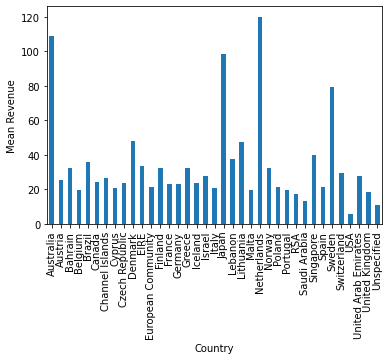

In [37]:
# Group by country
country_grp = df.groupby(['Country'])

# Lets take a look at mean, median and standard deviation revenue broken down by country 
#country_grp = country_grp['Revenue'].agg(['min', 'median', 'mean', 'std', 'max']).sort_values(by = ['mean'], ascending = False)
#country_grp

# Mean Revenue By Country
country_rev = country_grp['Revenue'].mean().plot(kind='bar')
country_rev.set_xlabel("Country")
country_rev.set_ylabel("Mean Revenue")

**2. Sales Revenue broken down by month** 

Text(0, 0.5, 'Monthly Revenue')

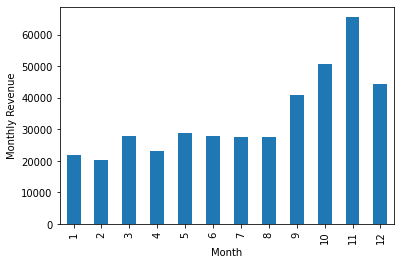

In [35]:
# Mean revenue per 
month_grp = df.groupby(['Month'])

# Mean Revenue Per Country
month_rev = month_grp['Revenue'].count().plot(kind='bar')
month_rev.set_xlabel("Month")
month_rev.set_ylabel("Monthly Revenue")

**Q2) What country is placing the most number of orders ?**

Text(17.200000000000003, 0.5, 'Mean Monthly Revenue')

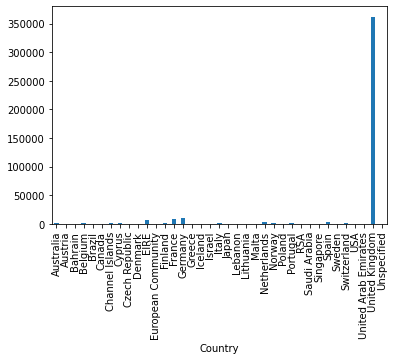

In [38]:
# Mean Revenue Per Country
count_rev = country_grp['CustomerID'].count().plot(kind='bar')
month_rev.set_xlabel("Country")
month_rev.set_ylabel("Mean Monthly Revenue")

In [39]:
country_count = df.groupby(['Country'])
country_count = country_grp['CustomerID'].agg(['count']).sort_values(by = ['count'], ascending = False)
country_count

,count
Country,
United Kingdom,361878
Germany,9495
France,8491
EIRE,7485
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,1877
Portugal,1480


# Market Segmentation